# Decision Tree Classification

## Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
data_test = pd.read_csv('drug_test.csv')
data_train = pd.read_csv('drug_train.csv')
data_unseen = pd.read_csv('drug_unseen.csv')
data_train.head()

,ID,AGE,SEX,BP,CHOLES,NA,K,DRUG
0,1,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,2,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,3,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,4,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,5,61,F,LOW,HIGH,0.559294,0.030998,drugY


In [ ]:
data_test.head()

,ID,AGE,SEX,BP,CHOLES,NA,K,DRUG
0,21,57,M,LOW,NORMAL,0.536746,0.028061,drugY
1,28,49,F,NORMAL,NORMAL,0.694689,0.074055,drugX
2,32,74,M,HIGH,HIGH,0.715337,0.074773,drugB
3,33,49,M,LOW,NORMAL,0.625889,0.056828,drugX
4,34,65,F,HIGH,NORMAL,0.828898,0.026004,drugY


In [ ]:
data_unseen.head()

,ID,AGE,SEX,BP,CHOLES,NA,K,DRUG
0,21,57,M,LOW,NORMAL,0.536746,0.028061,NaN
1,28,49,F,NORMAL,NORMAL,0.694689,0.074055,NaN
2,32,74,M,HIGH,HIGH,0.715337,0.074773,NaN
3,33,49,M,LOW,NORMAL,0.625889,0.056828,NaN
4,34,65,F,HIGH,NORMAL,0.828898,0.026004,NaN


# 2) Exploration

## 2.1) What is the number of classes to be classified?

In [ ]:
drug_class = data_test['DRUG'].unique()
print(f'the number of classes is : {len(drug_class)}')

the number of classes is : 5


## 2.2) What proportion of the patients responded to each class, in the training dataset?

In [ ]:
count_data = dict(data_train['DRUG'].value_counts().sort_index())
rows = len(data_train)
for key,value in count_data.items():
  print(f"Drug Name : {key}    Occurrences : {value}    % : {(value/rows)*100}")

Drug Name : drugA    Occurrences : 23    % : 11.5
Drug Name : drugB    Occurrences : 16    % : 8.0
Drug Name : drugC    Occurrences : 16    % : 8.0
Drug Name : drugX    Occurrences : 54    % : 27.0
Drug Name : drugY    Occurrences : 91    % : 45.5


# 3) Pre-processing

## 3.1) Generate Attribute:
Create a new field, call it Na_to_K. Create a derived field, Na_to_K, and filter out the original fields, Na and K, so that they are not used twice in the modeling algorithm.

In [ ]:
data_train["Na_to_K"] = data_train["NA"]/data_train["K"]
data_test["Na_to_K"] = data_test["NA"]/data_test["K"]
data_unseen["Na_to_K"] = data_unseen["NA"]/data_unseen["K"]

filter out the original fields, Na and K,

In [ ]:
data_train = data_train.drop(['ID','NA','K'],axis=1)
data_test = data_test.drop(['ID','NA','K'],axis=1)
data_unseen = data_unseen.drop(['ID','NA','K'],axis=1)
data_train.head()

,AGE,SEX,BP,CHOLES,DRUG,Na_to_K
0,23,F,HIGH,HIGH,drugY,25.354629
1,47,M,LOW,HIGH,drugC,13.092530
2,47,M,LOW,HIGH,drugC,10.113556
3,28,F,NORMAL,HIGH,drugX,7.797618
4,61,F,LOW,HIGH,drugY,18.042906


## 3.2) Discretization: Discretize Na_to_K in to the following rages: Low: <= 10; Medium: <= 20; High: <= 30; VeryHigh: <= 40

In [ ]:
data_train["Na_to_K"] = pd.cut(data_train["Na_to_K"],bins=[0, 10, 20, 30, 40], labels=["Low","Medium","High","VeryHigh"])
data_test["Na_to_K"] = pd.cut(data_test["Na_to_K"],bins=[0, 10, 20, 30, 40], labels=["Low","Medium","High","VeryHigh"])
data_unseen["Na_to_K"] = pd.cut(data_unseen["Na_to_K"],bins=[0, 10, 20, 30, 40], labels=["Low","Medium","High","VeryHigh"])
data_train.head()

,AGE,SEX,BP,CHOLES,DRUG,Na_to_K
0,23,F,HIGH,HIGH,drugY,High
1,47,M,LOW,HIGH,drugC,Medium
2,47,M,LOW,HIGH,drugC,Medium
3,28,F,NORMAL,HIGH,drugX,Low
4,61,F,LOW,HIGH,drugY,Medium


In [ ]:
encoded_train = pd.get_dummies(data_train, columns = ["SEX","BP","CHOLES","Na_to_K"])
encoded_test = pd.get_dummies(data_test, columns = ["SEX","BP","CHOLES","Na_to_K"])
encoded_unseen = pd.get_dummies(data_unseen, columns = ["SEX","BP","CHOLES","Na_to_K"])

In [ ]:
X_train = encoded_train.drop(['DRUG'],axis=1)
y_train = encoded_train['DRUG']
X_test = encoded_test.drop(['DRUG'],axis=1)
y_test = encoded_test['DRUG']

In [ ]:
print(X_train)

     AGE  SEX_F  SEX_M  BP_HIGH  BP_LOW  BP_NORMAL  CHOLES_HIGH  \
0     23   True  False     True   False      False         True   
1     47  False   True    False    True      False         True   
2     47  False   True    False    True      False         True   
3     28   True  False    False   False       True         True   
4     61   True  False    False    True      False         True   
..   ...    ...    ...      ...     ...        ...          ...   
195   56   True  False    False    True      False         True   
196   16  False   True    False    True      False         True   
197   52  False   True    False   False       True         True   
198   23  False   True    False   False       True        False   
199   40   True  False    False    True      False        False   

     CHOLES_NORMAL  Na_to_K_Low  Na_to_K_Medium  Na_to_K_High  \
0            False        False           False          True   
1            False        False            True         False   


# 4) Model Construction

## 4.1) What is the number of levels in your tree?

In [ ]:
classifier = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

[Text(0.4583333333333333, 0.875, 'x[3] <= 0.5\nentropy = 1.969\nsamples = 200\nvalue = [23, 16, 16, 54, 91]'),
 Text(0.25, 0.625, 'x[10] <= 0.5\nentropy = 1.428\nsamples = 123\nvalue = [0, 0, 16, 54, 53]'),
 Text(0.16666666666666666, 0.375, 'x[5] <= 0.5\nentropy = 1.43\nsamples = 102\nvalue = [0, 0, 16, 54, 32]'),
 Text(0.08333333333333333, 0.125, 'entropy = 1.583\nsamples = 52\nvalue = [0, 0, 16, 18, 18]'),
 Text(0.25, 0.125, 'entropy = 0.855\nsamples = 50\nvalue = [0, 0, 0, 36, 14]'),
 Text(0.3333333333333333, 0.375, 'entropy = 0.0\nsamples = 21\nvalue = [0, 0, 0, 0, 21]'),
 Text(0.6666666666666666, 0.625, 'x[0] <= 50.5\nentropy = 1.495\nsamples = 77\nvalue = [23, 16, 0, 0, 38]'),
 Text(0.5, 0.375, 'x[10] <= 0.5\nentropy = 0.995\nsamples = 50\nvalue = [23, 0, 0, 0, 27]'),
 Text(0.4166666666666667, 0.125, 'entropy = 0.977\nsamples = 39\nvalue = [23, 0, 0, 0, 16]'),
 Text(0.5833333333333334, 0.125, 'entropy = 0.0\nsamples = 11\nvalue = [0, 0, 0, 0, 11]'),
 Text(0.8333333333333334, 0.37

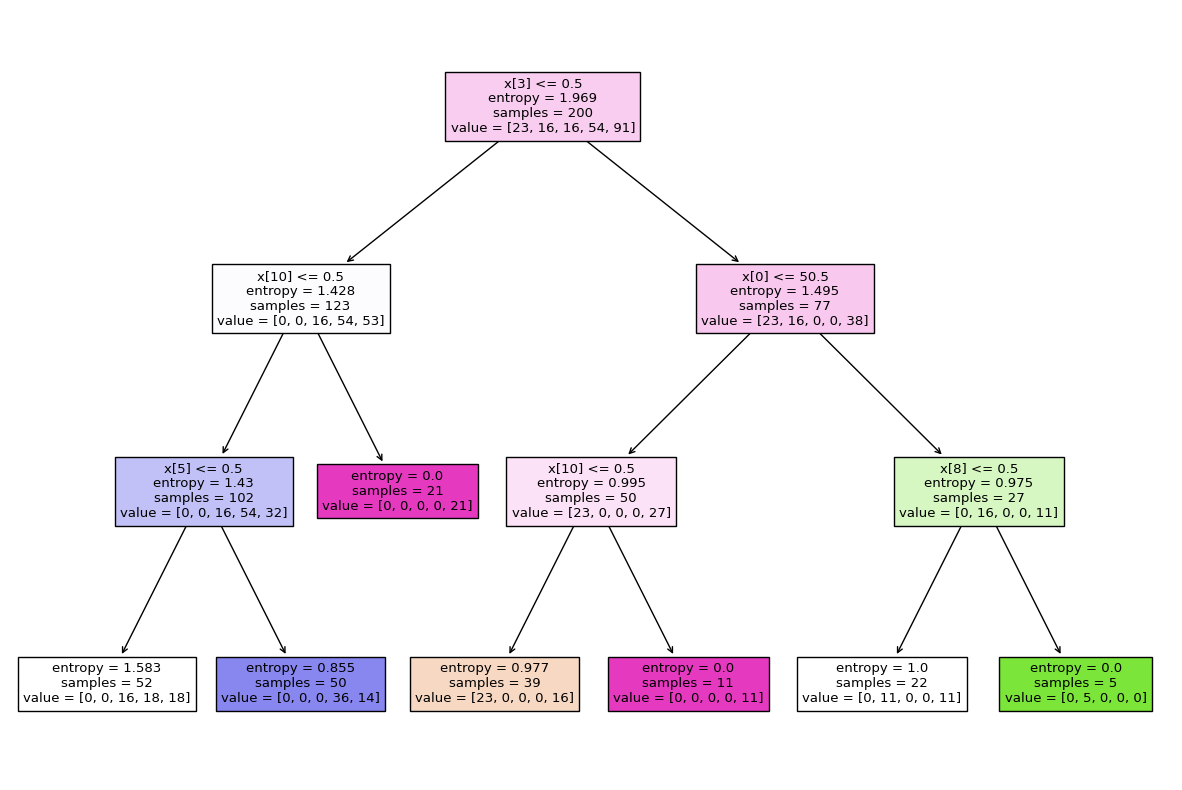

In [ ]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(classifier,filled=True)

number of levels in tree is 3

## 4.2) Express the resulting tree as a set of rules.

In [ ]:
print(tree.export_text(classifier))

|--- feature_3 <= 0.50
|   |--- feature_10 <= 0.50
|   |   |--- feature_5 <= 0.50
|   |   |   |--- class: drugX
|   |   |--- feature_5 >  0.50
|   |   |   |--- class: drugX
|   |--- feature_10 >  0.50
|   |   |--- class: drugY
|--- feature_3 >  0.50
|   |--- feature_0 <= 50.50
|   |   |--- feature_10 <= 0.50
|   |   |   |--- class: drugA
|   |   |--- feature_10 >  0.50
|   |   |   |--- class: drugY
|   |--- feature_0 >  50.50
|   |   |--- feature_8 <= 0.50
|   |   |   |--- class: drugB
|   |   |--- feature_8 >  0.50
|   |   |   |--- class: drugB



## 4.3) Which attribute is the most related to Drug

In [ ]:
important = classifier.feature_importances_
feature_important = pd.Series(important,index=X_train.columns)
feature_important.sort_values(ascending=False)

,0
BP_HIGH,0.494230
Na_to_K_High,0.198679
AGE,0.186885
BP_NORMAL,0.099456
Na_to_K_Low,0.020750
SEX_F,0.000000
SEX_M,0.000000
BP_LOW,0.000000
CHOLES_HIGH,0.000000
CHOLES_NORMAL,0.000000


BP is the most related to Drug

# 5) Performance evaluation

## 5.1) What is the overall accuracy/error of your model against the testing set?

In [ ]:
score = accuracy_score(y_test, y_pred)
print(score)

0.7142857142857143


## 5.2) Give precision/recall of each class?

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         2
       drugB       0.75      1.00      0.86         3
       drugC       0.00      0.00      0.00         2
       drugX       0.57      1.00      0.73         4
       drugY       1.00      0.33      0.50         3

    accuracy                           0.71        14
   macro avg       0.66      0.67      0.62        14
weighted avg       0.68      0.71      0.64        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 6) Propose your best model

## Training the Decision Tree Classification model on the Training set

In [ ]:
from math import log2
md = round(log2(len(X_train.columns)))
print(f'max_depth is : {md}')

max_depth is : 4


In [ ]:
myClassifier = tree.DecisionTreeClassifier(max_depth = md, criterion = 'entropy', random_state = 0)
myClassifier.fit(X_train, y_train)
y_pred = myClassifier.predict(X_test)

In [ ]:
myScore = accuracy_score(y_test, y_pred)
print(myScore)

0.9285714285714286


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         2
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         2
       drugX       0.80      1.00      0.89         4
       drugY       1.00      0.67      0.80         3

    accuracy                           0.93        14
   macro avg       0.96      0.93      0.94        14
weighted avg       0.94      0.93      0.93        14



[Text(0.5294117647058824, 0.9, 'x[3] <= 0.5\nentropy = 1.969\nsamples = 200\nvalue = [23, 16, 16, 54, 91]'),
 Text(0.29411764705882354, 0.7, 'x[10] <= 0.5\nentropy = 1.428\nsamples = 123\nvalue = [0, 0, 16, 54, 53]'),
 Text(0.23529411764705882, 0.5, 'x[5] <= 0.5\nentropy = 1.43\nsamples = 102\nvalue = [0, 0, 16, 54, 32]'),
 Text(0.11764705882352941, 0.3, 'x[7] <= 0.5\nentropy = 1.583\nsamples = 52\nvalue = [0, 0, 16, 18, 18]'),
 Text(0.058823529411764705, 0.1, 'entropy = 0.975\nsamples = 27\nvalue = [0, 0, 16, 0, 11]'),
 Text(0.17647058823529413, 0.1, 'entropy = 0.855\nsamples = 25\nvalue = [0, 0, 0, 18, 7]'),
 Text(0.35294117647058826, 0.3, 'x[8] <= 0.5\nentropy = 0.855\nsamples = 50\nvalue = [0, 0, 0, 36, 14]'),
 Text(0.29411764705882354, 0.1, 'entropy = 0.989\nsamples = 32\nvalue = [0, 0, 0, 18, 14]'),
 Text(0.4117647058823529, 0.1, 'entropy = 0.0\nsamples = 18\nvalue = [0, 0, 0, 18, 0]'),
 Text(0.35294117647058826, 0.5, 'entropy = 0.0\nsamples = 21\nvalue = [0, 0, 0, 0, 21]'),
 Tex

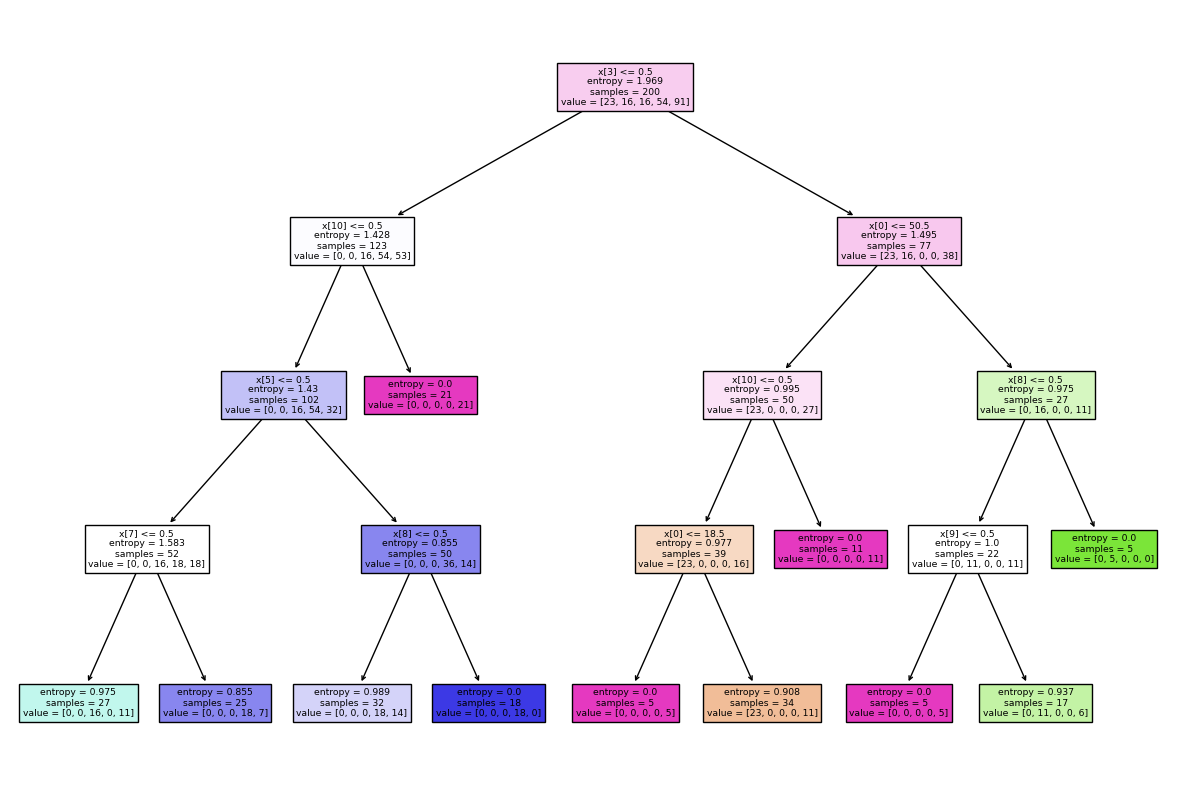

In [ ]:
plt.figure(figsize=(15,10))
tree.plot_tree(myClassifier,filled=True)

# 7) Prediction of Unseen

In [ ]:
X_unseen = encoded_unseen.drop(['DRUG'],axis=1)
y_unseen_pred = myClassifier.predict(X_unseen)
y_unseen_pred

array(['drugX', 'drugX', 'drugB', 'drugX', 'drugY', 'drugX', 'drugA',
       'drugC', 'drugB', 'drugC', 'drugA', 'drugY', 'drugX', 'drugB'],
      dtype=object)

In [ ]:
unseen_result = data_unseen.copy()
unseen_result['DRUG'] = y_unseen_pred
unseen_result

,AGE,SEX,BP,CHOLES,DRUG,Na_to_K
0,57,M,LOW,NORMAL,drugX,Medium
1,49,F,NORMAL,NORMAL,drugX,Low
2,74,M,HIGH,HIGH,drugB,Low
3,49,M,LOW,NORMAL,drugX,Medium
4,65,F,HIGH,NORMAL,drugY,VeryHigh
5,53,M,NORMAL,HIGH,drugX,Medium
6,32,M,HIGH,NORMAL,drugA,Low
7,68,M,LOW,HIGH,drugC,Medium
8,68,F,HIGH,NORMAL,drugB,Medium
9,26,F,LOW,HIGH,drugC,Medium
